In [1]:
# 导入相关包
import pandas as pd # 数据分析
import numpy as np # 数值计算
import seaborn as sns # 绘图
import matplotlib.pyplot as plt # 绘图
from sklearn.preprocessing import LabelEncoder, StandardScaler # 数据预处理
from sklearn.metrics import silhouette_score # 聚类模型评估
from sklearn.model_selection import train_test_split # 数据集处理
from sklearn.model_selection import StratifiedKFold # 交叉验证
from sklearn.model_selection import cross_val_score # 用于传递模型评估函数
from sklearn.cluster import KMeans # KMeans聚类
from sklearn.ensemble import RandomForestClassifier # 随机森林
from sklearn.ensemble import StackingClassifier # Stacking集成学习
from sklearn.metrics import accuracy_score  # 模型评估
from sklearn.metrics import confusion_matrix # 混淆矩阵
from skopt import BayesSearchCV # 贝叶斯优化
from skopt.space import Real, Integer # 贝叶斯优化参数
from xgboost import XGBClassifier # XGBoost
from lightgbm import LGBMClassifier # LightGBM

In [2]:
data = pd.read_csv("german_credit_data.csv") # 导入数据集
data.head() # 查看数据是否正确导入

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [3]:
data = data.drop(['Unnamed: 0'], axis = 1) # 由于第一列为索引，所以删除
data.head(5) # 查看数据

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [4]:
data.isna().sum() # 数据缺失情况

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [5]:
# 由于缺失的数据列Saving acount和 Checking account均为分类数据，且缺失数量较大，故残缺值暂时不处理
data['Saving accounts'].fillna('un', inplace=True) # 用un填充缺失值
data['Checking account'].fillna('un', inplace=True) # 用un填充缺失值
data.isna().sum() # 再次检查缺失值，确定填充完成

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

# EDA

## 性别、年龄分析

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


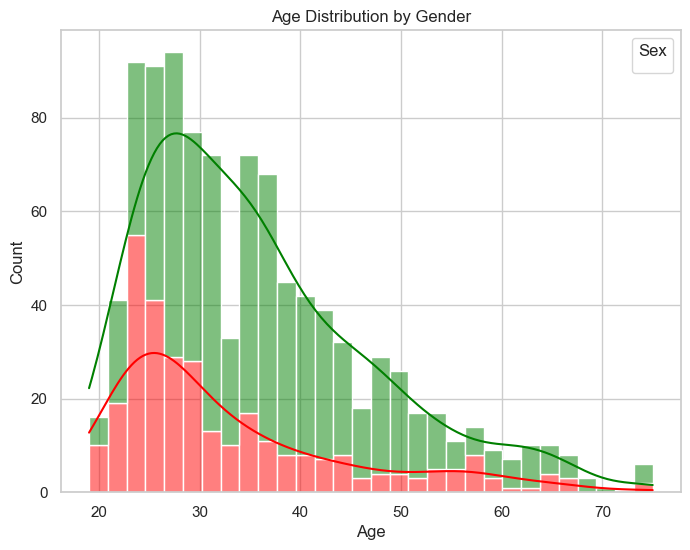

In [6]:
sns.set_theme(style="whitegrid") # 设置绘图主题

plt.figure(figsize=(8, 6)) # 设置绘图窗口大小

sns.histplot(data=data, x='Age', kde=True, bins=30, hue='Sex', palette={'male': 'green', 'female': 'red'}, multiple='stack') # 按性别分别绘制年龄分布变化图
plt.xlabel('Age') # 设置x轴标签
plt.ylabel('Count') # 设置y轴标签
plt.title('Age Distribution by Gender') # 设置标题
plt.legend(title='Sex') # 设置图例标题

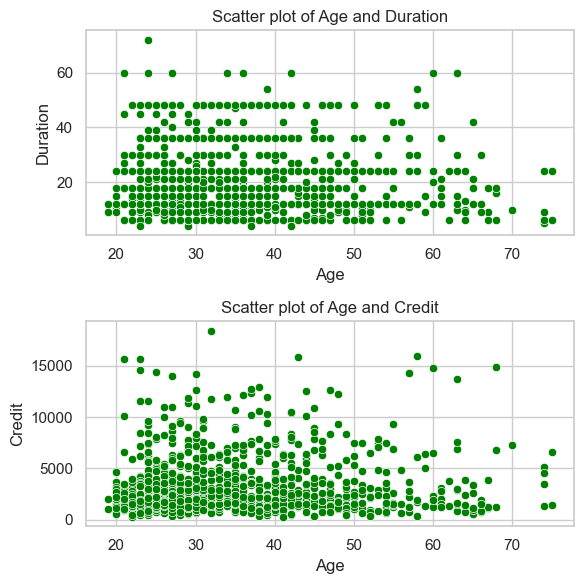

In [7]:
plt.figure(figsize=(6, 6)) # 设置绘图窗口大小

plt.subplot(211)  # 第一个子图
sns.scatterplot(data=data, x='Age', y='Duration', color='green') # 绘制年龄与贷款时长的散点图
plt.xlabel('Age') # 设置x轴标签
plt.ylabel('Duration') # 设置y轴标签
plt.title('Scatter plot of Age and Duration') # 设置标题

plt.subplot(212)  # 第二个子图
sns.scatterplot(data=data, x='Age', y='Credit amount', color='green') # 绘制年龄与贷款时长的散点图
plt.xlabel('Age') # 设置x轴标签
plt.ylabel('Credit') # 设置y轴标签
plt.title('Scatter plot of Age and Credit') # 设置标题

plt.tight_layout()  # 调整布局
plt.show() # 显示图像

# 采用聚类分析进行客户画像


## 特征工程

In [8]:
# 先进行数据处理，对分类变量进行编码，对数值变量进行标准化
features = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration'] # 从数据集中提取所有特征
encoded_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account'] # 编码特征
num_features = ['Age', 'Credit amount', 'Duration'] # 提取数值特征
data_processed = data[features].copy() # 复制一份新的数据，将用于预处理


In [9]:
# 编码
# label_encoders = {} # 用于存储编码对象
for feature in encoded_features: # 遍历需要编码的特征进行编码处理
    le = LabelEncoder() # 创建编码对象
    data_processed[feature] = le.fit_transform(data_processed[feature])  # 对特征进行编码
    # label_encoders[feature] = le # 保存编码对象

In [10]:
# 计算均值和标准差
mean_values = data_processed[num_features].mean() # 计算数值型特征的均值
std_values = data_processed[num_features].std() # 计算数值型特征的标准差

# 标准化数值型特征
for feature in num_features: # 遍历数值型特征进行标准化处理
    mean_val = mean_values[feature] # 获取该特征的均值
    std_val = std_values[feature] # 获取该特征的标准差
    data_processed[feature] = (data_processed[feature] - mean_val) / std_val # 对该特征的数据进行标准化

In [11]:
data_processed.head(10) # 输出部分数据，检查数据处理效果

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration
0,2.765073,1,2,1,4,0,-0.744759,-1.235859
1,-1.190808,0,2,1,0,1,0.949342,2.247070
2,1.182721,1,1,1,0,3,-0.416354,-0.738298
3,0.831087,1,2,0,0,0,1.633430,1.749509
4,1.534354,1,2,0,0,0,0.566380,0.256825
5,-0.047998,1,1,0,4,3,2.048984,1.251947
6,1.534354,1,2,1,2,3,-0.154551,0.256825
7,-0.047998,1,3,2,0,1,1.302545,1.251947
8,2.237622,1,1,1,3,3,-0.075196,-0.738298
9,-0.663357,1,3,1,0,1,0.695333,0.754386


## 聚类模型

In [12]:
# 使用肘部法来确定聚类数
clusters_range = range(2, 11) # 聚类数K的尝试范围
inertias = [] #K对应的聚类内部平方和，表示每个样本到其所属簇的中心点的距离的平方之和，越小越好
scores = [] # K对应的平均轮廓系数，接近1表示样本聚类合适，接近0表示样本在聚类边界，接近-1表示样本被错误地分配到相邻的聚类，越大越好
for k in clusters_range: # 尝试不同的聚类数
    kmeans = KMeans(n_clusters=k, random_state=10).fit(data_processed) # 创建KMeans模型并拟合数据
    inertias.append(kmeans.inertia_) # 添加聚类内部平方和
    scores.append(silhouette_score(data_processed, kmeans.labels_)) # 添加平均轮廓系数

d:\Complier\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Complier\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Complier\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Complier\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Complier\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarni

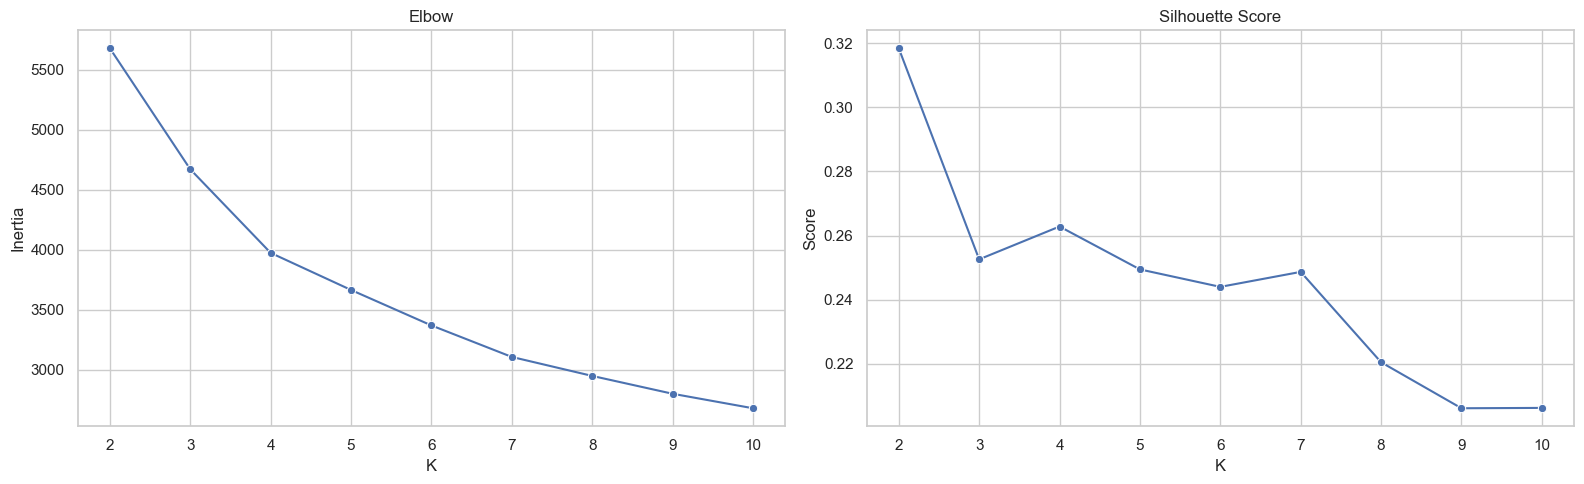

In [13]:
plt.figure(figsize=(16, 5)) # 设置绘图窗口大小

plt.subplot(121) # 第一个子图
sns.lineplot(x=clusters_range, y=inertias, marker='o') # 绘制肘部折线图
plt.xlabel('K') # 设置x轴标签
plt.ylabel('Inertia') # 设置y轴标签
plt.title('Elbow') # 设置标题

plt.subplot(122) # 第二个子图
sns.lineplot(x=clusters_range, y=scores, marker='o') # 绘制轮廓函数折线图  
plt.xlabel('K') # 设置x轴标签
plt.ylabel('Score') # 设置y轴标签
plt.title('Silhouette Score') # 设置标题

plt.tight_layout() # 调整布局 
plt.show() # 显示图像



根据肘部图和轮廓函数，均衡考虑后，决定选择K = 4，即使得inertias曲线出现拐点，又取得了较高的轮廓函数

In [14]:
# K-means聚类
kmeans_res = KMeans(n_clusters=4, random_state=25) # 选择聚类的簇数量为4
kmeans_res.fit(data_processed) # 进行聚类
cluster_labels = kmeans_res.labels_ # 获得聚类标签
data['Cluster'] = cluster_labels # 给数据添加新的列，存储聚类结果

d:\Complier\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## 根据聚类结果进行客户画像

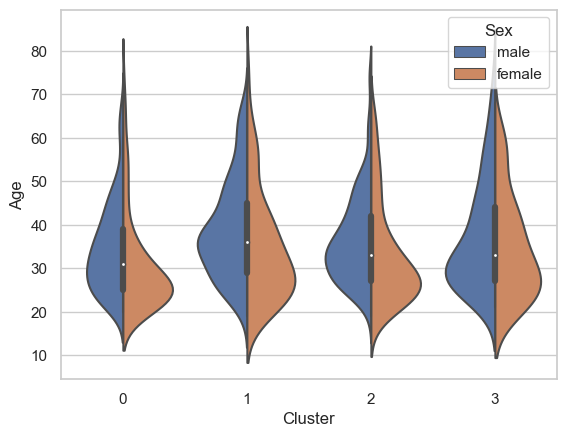

In [15]:
# 按照性别、年龄绘制聚类结果图
sns.violinplot(x='Cluster', y='Age', hue='Sex', data=data, split=True) # 绘制小提琴图
plt.show() # 显示图像

In [16]:
# 计算各特征在每个聚类簇中的比例
cluster_job_percentages = data.groupby('Job')['Cluster'].value_counts(normalize=True).unstack() # 计算每个Cluster中每个Job的占比
cluster_housing_percentages = data.groupby('Housing')['Cluster'].value_counts(normalize=True).unstack() # 计算每个Cluster中每个Housing的占比
cluster_saving_percentages = data.groupby('Saving accounts')['Cluster'].value_counts(normalize=True).unstack() # 计算每个Cluster中每个Saving accounts的占比
cluster_checking_percentages = data.groupby('Checking account')['Cluster'].value_counts(normalize=True).unstack()  # 计算每个Cluster中每个Checking account的占比
cluster_purpose_percentages = data.groupby('Purpose')['Cluster'].value_counts(normalize=True).unstack() # 计算每个Cluster中每个Purpose的占比


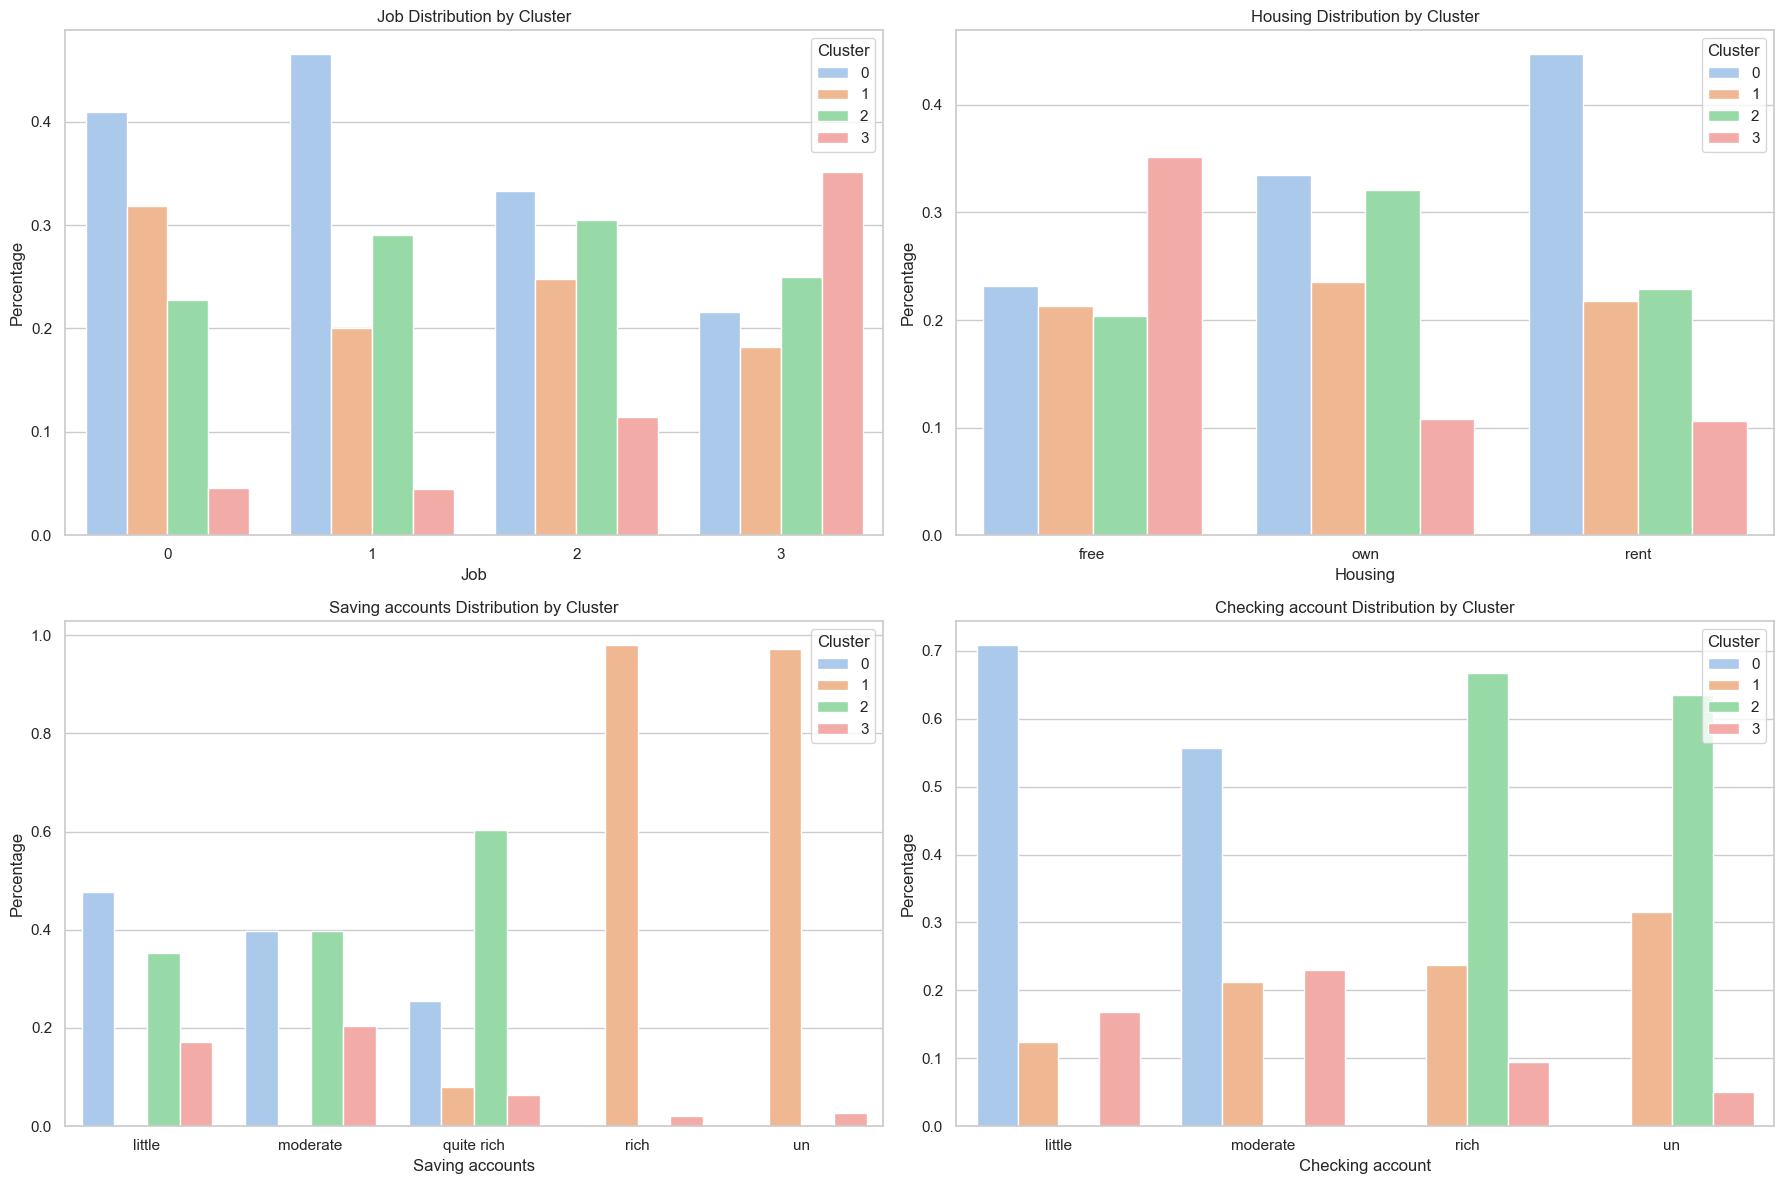

In [17]:
# 将聚类中各个特征的比例堆叠，便于绘制堆叠柱状图
cluster_job_percentages_stacked = cluster_job_percentages.stack().reset_index(name='value') # 将cluster_job_percentages的多层索引堆叠，然后重置索引，并将堆叠后的数据重命名
cluster_housing_percentages_stacked = cluster_housing_percentages.stack().reset_index(name='value') # 将cluster_housing_percentages的多层索引堆叠，然后重置索引，并将堆叠后的数据重命名
cluster_saving_percentages_stacked = cluster_saving_percentages.stack().reset_index(name='value') # 将cluster_saving_percentages的多层索引堆叠，然后重置索引，并将堆叠后的数据重命名
cluster_checking_percentages_stacked = cluster_checking_percentages.stack().reset_index(name='value') # 将cluster_checking_percentages的多层索引堆叠，然后重置索引，并将堆叠后的数据重命名

plt.figure(figsize=(18, 12)) # 设置绘图窗口大小

plt.subplot(221) # 第一个子图
sns.barplot(x='Job', y='value', hue='Cluster', data=cluster_job_percentages_stacked, palette='pastel') # 绘制 Job 的比例堆叠柱状图
plt.xlabel('Job') # 设置x轴标签
plt.ylabel('Percentage') # 设置y轴标签
plt.legend(title='Cluster', loc='upper right') # 设置图例
plt.title('Job Distribution by Cluster') # 设置标题

plt.subplot(222) # 第二个子图
sns.barplot(x='Housing', y='value', hue='Cluster', data=cluster_housing_percentages_stacked, palette='pastel') # 绘制 Housing 的比例堆叠柱状图
plt.xlabel('Housing') # 设置x轴标签
plt.ylabel('Percentage') # 设置y轴标签
plt.legend(title='Cluster', loc='upper right') # 设置图例
plt.title('Housing Distribution by Cluster') # 设置标题

plt.subplot(223) # 第三个子图
sns.barplot(x='Saving accounts', y='value', hue='Cluster', data=cluster_saving_percentages_stacked, palette='pastel') # 绘制 Saving accounts 的比例堆叠柱状图
plt.title('Saving accounts Distribution by Cluster')
plt.xlabel('Saving accounts')
plt.ylabel('Percentage')
plt.legend(title='Cluster', loc='upper right')

plt.subplot(224) # 第四个子图
sns.barplot(x='Checking account', y='value', hue='Cluster', data=cluster_checking_percentages_stacked, palette='pastel') # 绘制 Checking account 的比例堆叠柱状图
plt.xlabel('Checking account') # 设置x轴标签
plt.ylabel('Percentage') # 设置y轴标签
plt.legend(title='Cluster', loc='upper right') # 设置图例
plt.title('Checking account Distribution by Cluster') # 设置标题

plt.tight_layout() # 调整子图布局
plt.show() # 显示图形


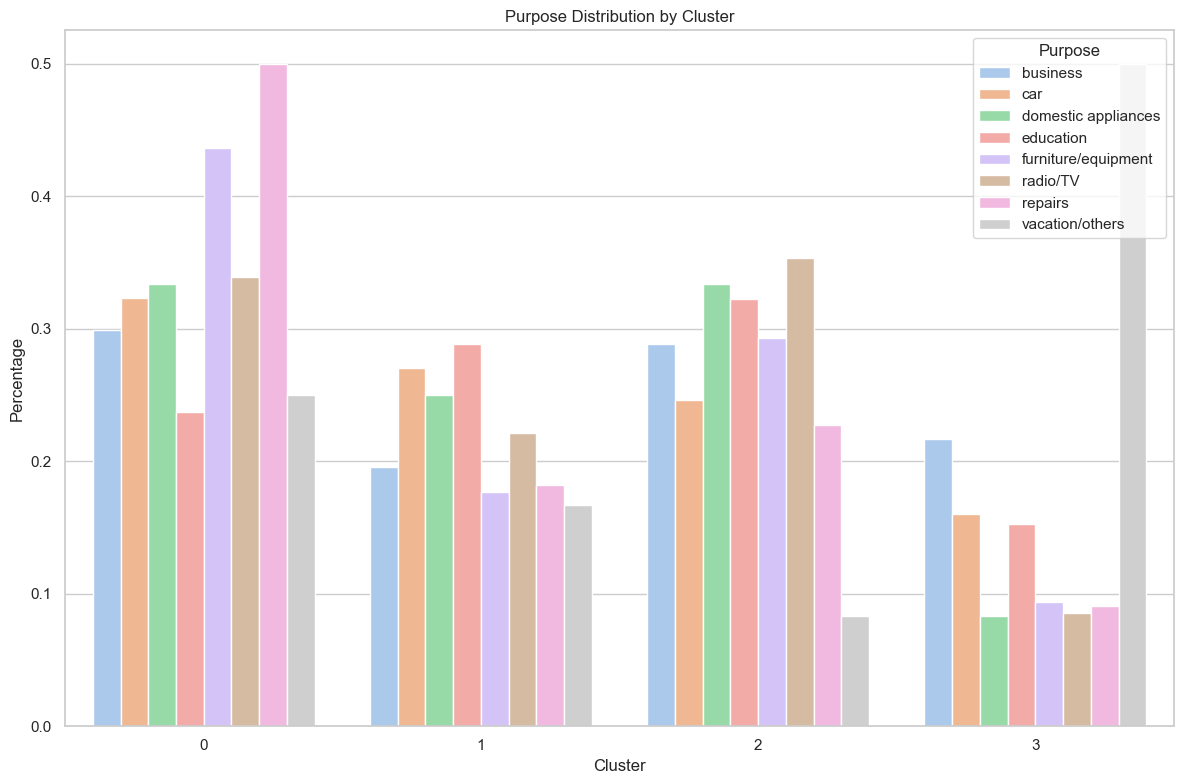

In [18]:
cluster_purpose_percentages_stacked = cluster_purpose_percentages.stack().reset_index(name='percentage') # 计算不同 Cluster 中各个 Purpose 的比例

plt.figure(figsize=(12, 8)) # 设置绘图窗口大小
sns.barplot(x='Cluster', y='percentage', hue='Purpose', data=cluster_purpose_percentages_stacked, palette='pastel') # 绘制柱状图
plt.xlabel('Cluster') # 设置x轴标签
plt.ylabel('Percentage') # 设置y轴标签
plt.legend(title='Purpose', loc='upper right') # 设置图例
plt.title('Purpose Distribution by Cluster') # 设置标题
plt.tight_layout() # 调整布局
plt.show() # 显示图像


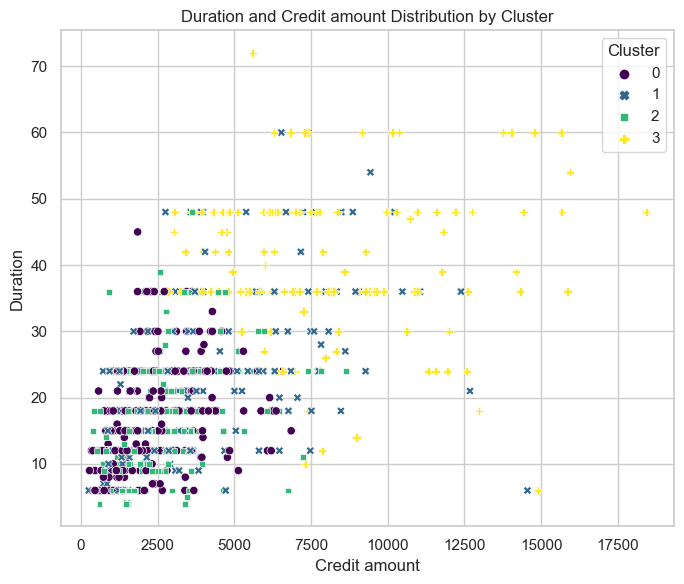

In [19]:
plt.figure(figsize=(7, 6)) # 设置绘图窗口大小
sns.scatterplot(data=data, x='Credit amount',  y='Duration', hue='Cluster', palette='viridis', style='Cluster') # 横坐标取贷款金额，纵坐标为贷款时长，绘制散点图
plt.ylabel('Duration') # 设置y轴
plt.xlabel('Credit amount') # 设置x轴
plt.legend(title='Cluster') # 设置图例
plt.title('Duration and Credit amount Distribution by Cluster') # 设置标题
plt.tight_layout() # 调整布局
plt.show() # 显示图像

# 多模Stacking进行风险客户画像

## 确定风险客户分类

d:\Complier\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

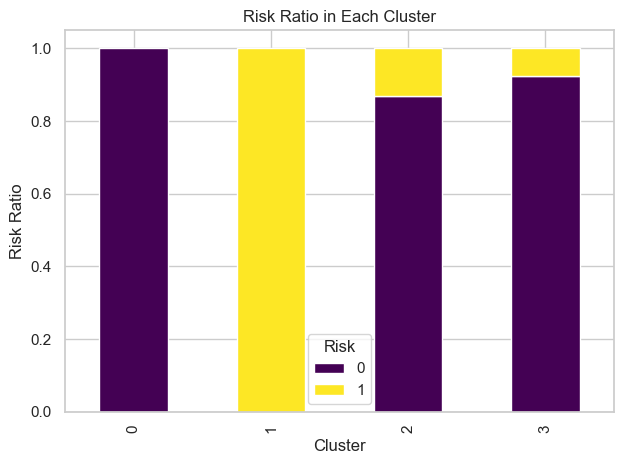

d:\Complier\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

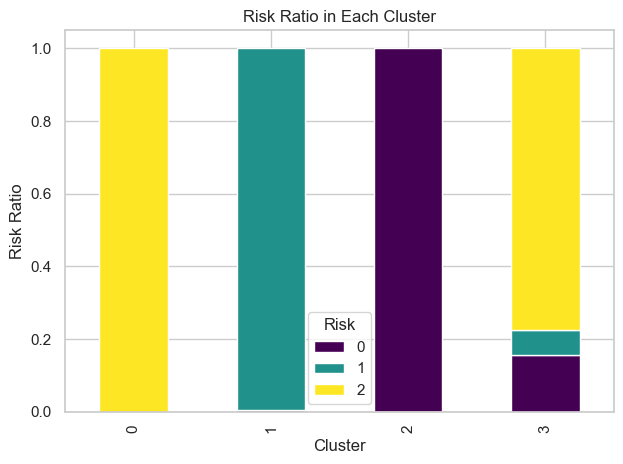

In [20]:

def cluster_and_plot(n_clusters, data_processed): # 聚类并绘图的函数
    kmeans_res_risk = KMeans(n_clusters=n_clusters, random_state=25) # 按照输入的簇n_clusters创建聚类模型
    kmeans_res_risk.fit(data_processed) # 进行聚类
    risk_cluster_labels = kmeans_res_risk.labels_ # 获得聚类标签
    data['Risk'] = risk_cluster_labels # 添加新的列，存储聚类结果
    # 按 Cluster 分组，并统计每个 Cluster 中 Risk 的数量，缺失值填充0，因为簇不同，会导致有些标签数量可能为0（簇数量少于标签数）
    risk_counts = data.groupby('Cluster')['Risk'].value_counts().unstack().fillna(0) 
    risk_ratios = risk_counts.div(risk_counts.sum(axis=1), axis=0) # 计算每个risk类在每个客户画像聚类中的比例
    plt.figure(figsize=(10, 6)) # 设置绘图窗口大小
    risk_ratios.plot(kind='bar', stacked=True, colormap='viridis') # 绘制堆叠柱状形图
    plt.xlabel('Cluster') # 设置x轴标签
    plt.ylabel('Risk Ratio') # 设置y轴标签
    plt.legend(title='Risk', labels=[str(i) for i in range(risk_counts.shape[1])]) # 根据不同的聚类数量设置图例标签
    plt.title('Risk Ratio in Each Cluster') # 设置标题
    plt.tight_layout() # 调整布局
    plt.show() # 显示图像

# 聚类并绘图
cluster_and_plot(2, data_processed) # n=2进行聚类 
cluster_and_plot(3, data_processed) # n=3进行聚类


d:\Complier\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

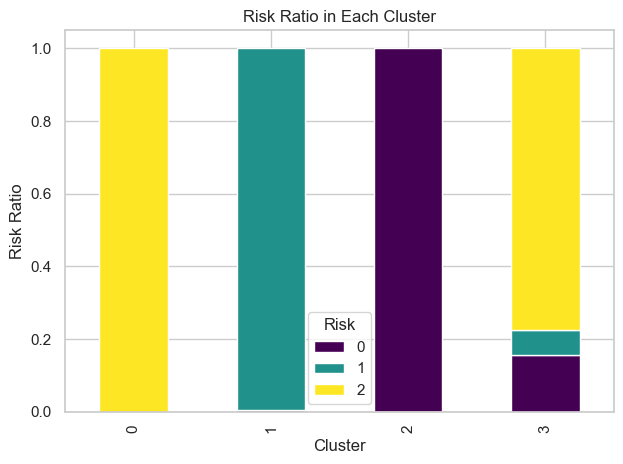

2    448
0    314
1    238
Name: Risk, dtype: int64


In [21]:
cluster_and_plot(3, data_processed) # n=3进行聚类
print(data['Risk'].value_counts()) # 查看数据集的Risk聚类结果

样本分布相对均衡，暂不进行重采样

## 建立分类模型

由于特征仅10个，故不进行筛选

In [22]:
combined_data = pd.concat([data_processed, data['Risk']], axis=1) # 将处理后的用于聚类的数据和Risk列合并
print(combined_data.columns) # 打印合并后的特征名来检查合并情况
print(combined_data.head()) # 输出合并后的几行数据来检查合并情况

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Risk'],
      dtype='object')
        Age  Sex  Job  Housing  Saving accounts  Checking account  \
0  2.765073    1    2        1                4                 0   
1 -1.190808    0    2        1                0                 1   
2  1.182721    1    1        1                0                 3   
3  0.831087    1    2        0                0                 0   
4  1.534354    1    2        0                0                 0   

   Credit amount  Duration  Risk  
0      -0.744759 -1.235859     1  
1       0.949342  2.247070     2  
2      -0.416354 -0.738298     0  
3       1.633430  1.749509     2  
4       0.566380  0.256825     2  


In [23]:
train_data,test_data = train_test_split(combined_data, test_size=0.1, random_state=2025, stratify=combined_data['Risk']) # 由于缺少测试集，将数据集进行人为划分，设定训练集和测试集
# 再把训练集进行划分
train_data_stk, test_data_stk = train_test_split(train_data, test_size=0.05, random_state=2024, stratify=train_data['Risk']) # 划分训练集和测试集 用于Stacking
train_data_rf, test_data_rf = train_test_split(train_data, test_size=0.01, random_state=2023, stratify=train_data['Risk']) # 划分训练集和测试集 用于RandomForest超参数调优
train_data_xgb, test_data_xgb = train_test_split(train_data, test_size=0.01, random_state=2022, stratify=train_data['Risk']) # 划分训练集和测试集 用户XGBoost超参数调优
train_data_lgb, test_data_lgb = train_test_split(train_data, test_size=0.01, random_state=2021, stratify=train_data['Risk']) # 划分训练集和测试集 用于LightGBM超参数调优

In [24]:
# 查看划分结果
print(len(train_data_stk),len(test_data_stk)) # 输出用于Stacking的训练集和测试集样本数
print(len(train_data_rf),len(test_data_rf)) # 输出用于rf的训练集和测试集样本数
print(len(train_data_xgb),len(test_data_xgb)) # 输出用于xgb的训练集和测试集样本数
print(len(train_data_lgb),len(test_data_lgb)) # 输出用于lgb的训练集和测试集样本数
print(train_data_stk.dtypes) # 查看数据类型检查

855 45
891 9
891 9
891 9
Age                 float64
Sex                   int32
Job                   int64
Housing               int32
Saving accounts       int32
Checking account      int32
Credit amount       float64
Duration            float64
Risk                  int32
dtype: object


In [25]:
# Stacking的训练集
X_train_stk = train_data_stk.drop('Risk',axis=1) # 删除掉标签列，获得训练用的输入X
y_train_stk = train_data_stk['Risk'] # 获获得标签列，即训练集的标签，获得训练结果的输出标签y
# RF的超参数优化训练集
X_train_rf = train_data_rf.drop('Risk',axis=1) # 删除掉标签列，获得训练用的输入X
y_train_rf = train_data_rf['Risk'] # 获得标签列，即训练集的标签，获得训练结果的输出标签y
# XGB的超参数优化训练集
X_train_xgb = train_data_xgb.drop('Risk',axis=1) # 删除掉标签列，获得训练用的输入X
y_train_xgb = train_data_xgb['Risk'] # 获得标签列，即训练集的标签，获得训练结果的输出标签y
# LGB的超参数优化训练集
X_train_lgb = train_data_lgb.drop('Risk',axis=1) # 删除掉标签列，获得训练用的输入X
y_train_lgb = train_data_lgb['Risk'] # 获得标签列，即训练集的标签，获得训练结果的输出标签y

In [26]:
X_test_stk = test_data.drop('Risk', axis=1) # 把先前划分的测试集作为Stacking的测试集，获得预测用的输入X
y_test_stk = test_data['Risk'] # 测试机的输出标签y

In [27]:
# BayesSearchCV 在内部调用 rf_cv 函数来计算准确率
def rf_cv(n_estimators, max_depth):
    model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=2024) # 创建rf模型
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024) # 采用10折交叉验证
    scores = cross_val_score(model, X_train_rf, y_train_rf, cv=cv, scoring='accuracy') # 设置准确率作为评分
    return scores.mean() # 返回平均准确率

# 定义超参数搜索空间
param_space = {
    'n_estimators': Integer(10, 200),  # 决策树数量
    'max_depth': Integer(1, 50),  # 决策树最大深度
    'min_samples_split': Integer(2, 20)  # 内部节点再划分所需最小样本数
}


# 创建贝叶斯优化器
rf_opt = BayesSearchCV(
    RandomForestClassifier(random_state=2024),  # rf分类器
    param_space,  # 参数空间
    n_iter=30,  # 迭代次数
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=2024),  # 10折交叉验证
    scoring='accuracy',  # 准确率作为评分
    random_state=2024,  # 随机种子
    n_jobs=-1  # 并行工作数
)

# 定义回调函数，在每次迭代完成时输出当前最佳参数，观察优化过程
def on_step(optim_result):
    print("Best parameters: %s" % optim_result.x) # 输出当前最佳超参数组合

rf_opt.fit(X_train_rf, y_train_rf, callback=on_step) # 贝叶斯优化进行超参数优化


Best parameters: [29, 3, 89]
Best parameters: [29, 3, 89]
Best parameters: [29, 3, 89]
Best parameters: [29, 3, 89]
Best parameters: [29, 3, 89]
Best parameters: [29, 3, 89]
Best parameters: [29, 3, 89]
Best parameters: [29, 3, 89]
Best parameters: [29, 3, 89]
Best parameters: [29, 3, 89]
Best parameters: [29, 3, 89]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]
Best parameters: [12, 4, 26]


BayesSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2024, shuffle=True),
              estimator=RandomForestClassifier(random_state=2024), n_iter=30,
              n_jobs=-1, random_state=2024, scoring='accuracy',
              search_spaces={'max_depth': Integer(low=1, high=50, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=200, prior='uniform', transform='normalize')})

In [28]:
# 采用同样的方法对XGBoost和LightGBM进行超参数优化

# 定义 XGBoost超参数搜索空间
xgb_param_space = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),  # 学习率，对数分布
    'n_estimators': Integer(100, 1000),  # 决策树的数量
    'max_depth': Integer(1, 20),  # 树的最大深度
    'min_child_weight': Integer(1, 10),  # 子节点最小权重范围
    'subsample': Real(0.1, 1.0, 'uniform'),  # 子样本比例，均匀分布
    'colsample_bytree': Real(0.1, 1.0, 'uniform'),  # 树的特征采样比例，均匀分布
    'gamma': Real(0.01, 1.0, 'log-uniform'),  # 分裂节点时的最小损失，对数分布
}

# 创建 XGBoost模型
xgb_model = XGBClassifier(random_state=2024)

# 定义 LightGBM超参数搜索空间
lgb_param_space = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),  # 学习率，对数分布
    'n_estimators': Integer(100, 1000),  # 决策树的数量
    'max_depth': Integer(1, 20),  # 树的最大深度
    'num_leaves': Integer(2, 50),  # 每棵树的叶子节点数
    'subsample': Real(0.1, 1.0, 'uniform'),  # 子样本比例，均匀分布
    'colsample_bytree': Real(0.1, 1.0, 'uniform'),  # 树的特征采样比例，均匀分布
}

# 创建 LightGBM模型
lgb_model = LGBMClassifier(random_state=2024)

# 创建XGBoost的贝叶斯优化器
xgb_opt = BayesSearchCV(
    xgb_model,  # XGBoost分类器
    xgb_param_space,  # 参数空间
    n_iter=30,  # 迭代次数
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=2024),  # 10折交叉验证
    scoring='accuracy',  # 准确率作为评分
    random_state=2024,  # 随机种子
    n_jobs=-1  # 并行工作数
)

# 创建 LightGBM的贝叶斯优化器
lgb_opt = BayesSearchCV(
    lgb_model,  # LightGBM分类器
    lgb_param_space,  # 参数空间
    n_iter=30,  # 迭代次数
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=2024),  # 10折交叉验证
    scoring='accuracy',  # 准确率作为评分
    random_state=2024,  # 随机种子
    n_jobs=-1  # 并行工作数
)

xgb_opt.fit(X_train_xgb, y_train_xgb) # 对XGBoost进行贝叶斯优化求最优超参数
lgb_opt.fit(X_train_lgb, y_train_lgb) # 对LightGBM进行贝叶斯优化求最优超参数

print("XGBoost 最佳参数:", xgb_opt.best_params_) # 输出XGBoost最优超参数
print("LightGBM 最佳参数:", lgb_opt.best_params_) # 输出LightGBM最优超参数


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 8
[LightGBM] [Info] Start training from score -1.157555
[LightGBM] [Info] Start training from score -1.435758
[LightGBM] [Info] Start training from score -0.803383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [29]:
# 创建基础模型
base_models = [
    ('rf', RandomForestClassifier(**rf_opt.best_params_, random_state=2024)), # 使用最优超参数组合创建的rf
    ('xgb', XGBClassifier(**xgb_opt.best_params_, random_state=2024)), # 使用最优超参数组合创建的xgb
    ('lgb', LGBMClassifier(**lgb_opt.best_params_, random_state=2024)) # 使用最优超参数组合创建的lgb
]
meta_model = RandomForestClassifier(random_state=2024) # 使用rf作为元模型
# 创建Stacking模型
stack_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5) # 使用rf/xgb/lgb作为基础模型，rf作为元模型
# 训练Stacking模型
stack_model.fit(X_train_stk, y_train_stk) # 使用训练集进行训练


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 855, number of used features: 8
[LightGBM] [Info] Start training from score -1.156390
[LightGBM] [Info] Start training from score -1.437895
[LightGBM] [Info] Start training from score -0.803066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=12,
                                                       min_samples_split=4,
                                                       n_estimators=26,
                                                       random_state=2024)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=1.0, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feat...
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=2024, ...)),
                               ('lgb',
                                LGBMClassifier(colsample_bytree=0.6172971032345614,
                                               learning_rate=0.014507497543313324,
                                               max_depth=9, n_estimators=995,
                                               num_leaves=27, random_state=2024,
                                               subsample=0.8454174546425824))],
                   final_estimator=RandomForestClassifier(random_state=2024))

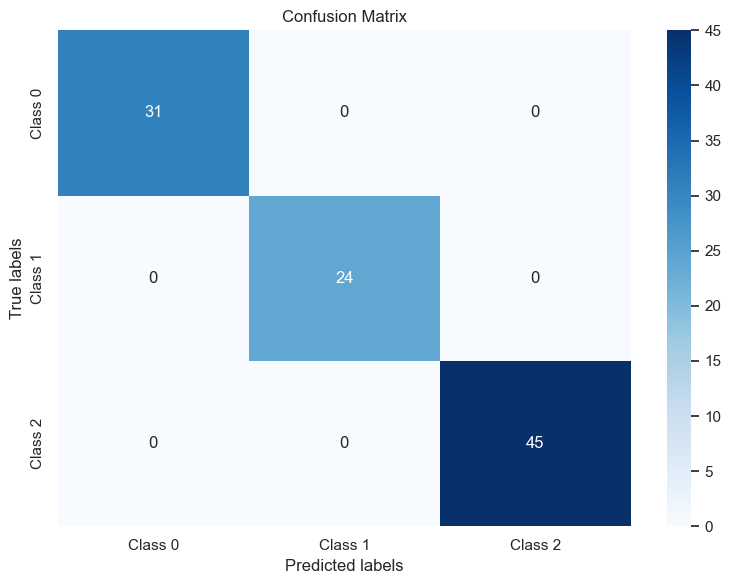

In [30]:
# 模型评估
# 预测结果
y_pred_stack = stack_model.predict(X_test_stk) # 使用测试集进行预测评估
conf_matrix = confusion_matrix(y_test_stk, y_pred_stack) # 计算混淆矩阵

# 绘制混淆矩阵热力图
plt.figure(figsize=(8, 6)) # 设置绘图窗口大小
# 根据混淆矩阵来绘制热力图
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2']) 
plt.xlabel('Predicted labels') # 设置x轴标签
plt.ylabel('True labels') # 设置y轴标签
plt.title('Confusion Matrix') # 设置标题
plt.tight_layout() # 调整布局
plt.show() # 显示图像
